### Парная линейная регрессия


#### Цель работы

Познакомиться с основными понятиями задачи регрессии и метода градиентного спуска.


#### Задания для выполнения



1. Загрузить данные о котировках нескольких инструментов с сайта РТС (следите за тем, чтобы периоды выгрузки совпадали, иначе весь наш анализ не будет иметь смысла).
    1. Можно взять не очень актуальные, но готовые данные в приложении (папка data).
2. Построить модель парной линейной регрессии с использованием метода градиентного спуска.
3. Оценить на графике качество построенной модели.
4. Построить кривые обучения.


#### Методические указания

Для полноценной работы с регрессионным анализом данных на потребуются следующие библиотеки языка Python:

```py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
```

Для начала считаем данные о котировке двух инструментов из csv-файла, полученного при импорте с сайта биржи в объект Pandas DataFrame:

```py
mvid = pd.read_csv('data/MVID_101001_171001.txt')
sber = pd.read_csv('data/SBER_101001_171001.txt')
```

Посмотрим формат файла с данными - состав и названия полей:

```py
sber.head()
```

<table>
  <tr>
   <td><code>&lt;TICKER></code>
   </td>
   <td><code>&lt;PER></code>
   </td>
   <td><code>&lt;DATE></code>
   </td>
   <td><code>&lt;TIME></code>
   </td>
   <td><code>&lt;CLOSE></code>
   </td>
   <td><code>&lt;VOL></code>
   </td>
   <td>
   </td>
  </tr>
  <tr>
   <td><code>0</code>
   </td>
   <td><code>SBER</code>
   </td>
   <td><code>D</code>
   </td>
   <td><code>20101001</code>
   </td>
   <td><code>0</code>
   </td>
   <td><code>89.09</code>
   </td>
   <td><code>332429890</code>
   </td>
  </tr>
  <tr>
   <td><code>1</code>
   </td>
   <td><code>SBER</code>
   </td>
   <td><code>D</code>
   </td>
   <td><code>20101004</code>
   </td>
   <td><code>0</code>
   </td>
   <td><code>89.88</code>
   </td>
   <td><code>194032721</code>
   </td>
  </tr>
  <tr>
   <td><code>2</code>
   </td>
   <td><code>SBER</code>
   </td>
   <td><code>D</code>
   </td>
   <td><code>20101005</code>
   </td>
   <td><code>0</code>
   </td>
   <td><code>91.97</code>
   </td>
   <td><code>198775753</code>
   </td>
  </tr>
  <tr>
   <td><code>3</code>
   </td>
   <td><code>SBER</code>
   </td>
   <td><code>D</code>
   </td>
   <td><code>20101006</code>
   </td>
   <td><code>0</code>
   </td>
   <td><code>91.20</code>
   </td>
   <td><code>210406027</code>
   </td>
  </tr>
  <tr>
   <td><code>4</code>
   </td>
   <td><code>SBER</code>
   </td>
   <td><code>D</code>
   </td>
   <td><code>20101007</code>
   </td>
   <td><code>0</code>
   </td>
   <td><code>90.40</code>
   </td>
   <td><code>145137617</code>
   </td>
  </tr>
</table>


Если проанализировать два этих объекта внимательнее мы увидим, что они имеют разную длину - разное количество наблюдений. Как это может быть, если выгрузка производилась за одинаковый период времени? Проблема в том, что инструмент в определенные периоды может не торговаться. Поэтому, данные в каждом файле могут в части дней отсутствовать. Таким образом, метки времени в двух файлах не обязательно должны идти одинаково последовательно. Как раз для выявления таких проблем с данными и необходимо проводить первоначальный визуальный анализ данных. 

Для разрешения нашей проблемы воспользуемся функцией merge из библиотеки pandas, которая и предназначена для соединения (в реляционном смысле) нескольких датасетов по ключевому полю:

```py
res = pd.merge(sber, mvid, on='&lt;DATE>')
res.head()
```

Затем выделим из получившегося объединенного датасета результативный и факторный признак. В нашем случае это будут цены закрытия двух этих инструментов:

```py
x = res['&lt;CLOSE>_x']
y = res['&lt;CLOSE>_y']
```

Для визуального представления совместного распределения значений используемых переменных построим график зависимости одной переменной от другой:

```py
plt.figure()
plt.scatter(x, y)
plt.show()
```

Мы видим, что в общем и целом, линейная зависимость прослеживается в данных. Значит, мы можем продолжать и использовать парную линейную регрессию.

Начнем строить класс, который будет реализовывать метод парной линейной регрессии:

```py
class hypothesis(object):
    """Модель парной линейной регрессии"""
    def __init__(self):
        self.b0 = 0
        self.b1 = 0
```

Здесь мы определили конструктор класса, который запоминает в полях экземпляра параметры регрессии. В дальнейшем мы сможем расширять функциональность этого класса сколь угодно много. 

Реализуем метод, который принимает значение входной переменной и возвращает теоретическое значение выходной - это прямое действие нашей регрессии - метод предсказания результата по факторам (в случае парной регрессии - по одному фактору): 

```py
    def predict(self, x):
        return self.b0 + self.b1 * x
```

Теперь зададим функцию ошибки:

```py
    def error(self, X, Y):    
        return sum((self.predict(X) - Y)**2) / (2 * len(X)) 
```

В данном случае мы используем простую функцию ошибки - среднеквадратическое отклонение (mean squared error, MSE). Можно использовать и другие функции ошибки. Именно вид функции ошибки будет определять то, какой вид регрессии мы реализуем. Существует много разных вариаций простого алгоритма регрессии. О большинстве распространенных методах регрессии можно почитать в официальной документации sklearn. 

Теперь реализуем метод градиентного спуска. Он должен принимать массив X и массив Y и обновлять параметры регрессии в соответствии в формулами градиентного спуска:

```py
    def BGD(self, X, Y):  
        alpha = 0.00005
        dJ0 = sum(self.predict(X) - Y) /len(X)
        dJ1 = sum((self.predict(X) - Y) * X) /len(X)
        self.b0 -= alpha * dJ0
        self.b1 -= alpha * dJ1
```

О выборе конкретного значения alpha - скорости обучения мы еще поговорим позднее.

Давайте создадим объект регрессии и проверим начальное значение ошибки:

```py
hyp = hypothesis()
print(hyp.predict(0))
print(hyp.predict(100))
J = hyp.error(x, y)
print("initial error:", J)
0 
0 
initial error: 36271.58344889084
```

Как мы видим, для начала оба параметра регрессии равны нулю. Конечно, такая модель не дает надежных предсказаний, но в этом и состоит метод градиентного спуска: начиная с любого решения мы постепенно его улучшаем и приходим к оптимальному решению.

Теперь изобразим нашу регрессию на графике:

```py
X0 = np.linspace(60, 180, 100)
Y0 = hyp.predict(X0)
plt.figure()
plt.scatter(x, y)
plt.plot(X0, Y0, 'r')
plt.show()
```

Теперь все готово к запуску градиентного спуска. 

```py
hyp.BGD(x, y)
J = hyp.error(x, y)
print("error after gradient descent:", J)
error after gradient descent: 6734.135540194945
X0 = np.linspace(60, 180, 100)
Y0 = hyp.predict(X0)
plt.figure()
plt.scatter(x, y)
plt.plot(X0, Y0, 'r')
plt.show()
```

Как мы видим, численное значение ошибки значительно уменьшилось. Да и линия на графике существенно приблизилось к точкам. Конечно, наша модель еще далека от совершенства. Мы прошли всего лишь одну итерацию градиентного спуска. Модифицируем метод так, чтобы он запускался в цикле пока ошибка не перестанет меняться существенно:

```py
    def BGD(self, X, Y, alpha=0.000005, accuracy=0.01, max_steps=5000):
        steps, errors = [], []
        step = 0        
        old_err = hyp.error(X, Y)
        new_err = hyp.error(X, Y) - 1
        dJ = 1
        while (dJ > accuracy) and (step&lt;max_steps):
            dJ0 = sum(self.predict(X) - Y) /len(X)
            dJ1 = sum((self.predict(X) - Y) * X) /len(X)
            self.b0 -= alpha * dJ0
            self.b1 -= alpha * dJ1            
            old_err = new_err
            new_err = hyp.error(X, Y)
            dJ = abs(old_err - new_err) 
            step += 1            
            steps.append(step)
            errors.append(new_err)
        return steps, errors
```

Заодно мы расширили функциональность этого метода так, чтобы он возвращал массив ошибок на каждой итерации спуска и номер итерации. Это будет нам полезно для построения кривых обучения.

Запустим наш градиентный спуск:

```py
hyp = hypothesis()
steps, errors = hyp.BGD(x, y)
J = hyp.error(x, y)
print("error after gradient descent:", J)
error after gradient descent: 298.76881676471504
```

Как мы видим, теперь ошибка снизилась гораздо больше. Однако, она все еще не достигла нуля. Заметим, что нулевая ошибка не всегда возможна в принципе из-за того, что точки данных не всегда будут располагаться на одной линии. Нужно стремиться не к нулевой, а к минимально возможной ошибке. 

Посмотрим, как теперь наша регрессия выглядит на графике:

```py
X0 = np.linspace(60, 180, 100)
Y0 = hyp.predict(X0)
plt.figure()
plt.scatter(x, y)
plt.plot(X0, Y0, 'r')
plt.show()
```

Уже значительно лучше. Линия регрессии довольно похожа на оптимальную. Так ли это на самом деле, глядя на график, сказать сложно, для этого нужно проанализировать, как ошибка регрессии менялась со временем:

```py
plt.figure()
plt.plot(steps, errors, 'g')
plt.show()
```

На графике наглядно видно, что в начале обучения ошибка падала быстро, но в ходе градиентного спуска она вышла на плато. Учитывая, что мы используем гладкую функцию ошибки второго порядка, это свидетельствует о том, что мы достигли локального оптимума и дальнейшее повторение алгоритма не принесет улучшения модели.

#### Контрольные вопросы

1. Сформулируйте задачу регрессии.
2. Что такое метод наименьших квадратов?
3. Какие функции ошибки используются в регрессионных моделях? Расскажите про три самые популярные.
4. Что показывает конкретное значение ошибки регрессии?
5. Зачем нужно строить кривые обучения?


#### Дополнительные задания

1. Реализуйте механизм адаптивной скорости обучения.
2. Постройте модель регрессии на другой паре инструментов.
3. Модифицируйте класс регрессии так, чтобы он проводил обучение только на случайно выделенной части данных (обучающей выборке). Историю динамики ошибки отслеживать отдельно по обучающей и по тестовой выборке. 
4. Научиться использовать библиотеку sklearn для построения парной линейной регрессии:
    1. Изучить официальную документацию библиотеки sklearn: [http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
    2. По примеру программы регрессии, рассмотренной на семинаре, построить модель регрессии с использованием библиотечных средств
    3. Сравнить результаты регрессии с использованием библиотечной функции и написанной самостоятельно.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [239]:
mvid = pd.read_csv('MVID_101001_171001.txt')
sber = pd.read_csv('SBER_101001_171001.txt')

In [240]:
mvid.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<CLOSE>,<VOL>
0,MVID,D,20101001,0,194.38,19406
1,MVID,D,20101004,0,190.00,31039
2,MVID,D,20101005,0,187.00,17651
3,MVID,D,20101006,0,190.04,36482
4,MVID,D,20101007,0,199.85,204248


In [241]:
mvid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758 entries, 0 to 1757
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   <TICKER>  1758 non-null   object 
 1   <PER>     1758 non-null   object 
 2   <DATE>    1758 non-null   int64  
 3   <TIME>    1758 non-null   int64  
 4   <CLOSE>   1758 non-null   float64
 5   <VOL>     1758 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 82.5+ KB


In [242]:
# join, merge
res = pd.merge(sber,mvid, on='<DATE>')
res.head()

,<TICKER>_x,<PER>_x,<DATE>,<TIME>_x,<CLOSE>_x,<VOL>_x,<TICKER>_y,<PER>_y,<TIME>_y,<CLOSE>_y,<VOL>_y
0,SBER,D,20101001,0,89.09,332429890,MVID,D,0,194.38,19406
1,SBER,D,20101004,0,89.88,194032721,MVID,D,0,190.00,31039
2,SBER,D,20101005,0,91.97,198775753,MVID,D,0,187.00,17651
3,SBER,D,20101006,0,91.20,210406027,MVID,D,0,190.04,36482
4,SBER,D,20101007,0,90.40,145137617,MVID,D,0,199.85,204248


In [243]:
x = res['<CLOSE>_x']
y = res['<CLOSE>_y']

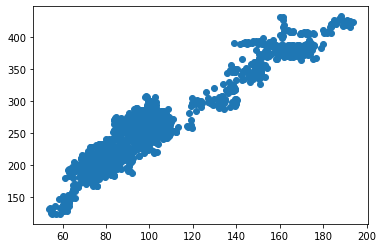

In [10]:
plt.scatter(x,y)

# линейная регрессия

In [197]:
class Model:
    def __init__(self):
        self.b0 = 0 # поля классов
        self.b1 = 0
    def predict(self,x):
        return self.b0 + self.b1*x
    def error(self, x, y):
        return sum(((self.predict(x) - y)**2)) / (2*len(y))
    def fit(self, x, y):
        alpha = 0.00001
        errors = []
        steps = []
        for i in range(100):
            steps.append(i)
            errors.append(self.error(x,y))
            dJ0 = sum((self.predict(x) - y)) / len(y) # градиент
            dJ1 = sum(((self.predict(x) - y)*x)) / len(y) # градиент
            self.b0 -= dJ0 * alpha
            self.b1 -= dJ1 * alpha
        return steps, errors

In [198]:
model = Model()
model.error(x,y)

36271.58344889084

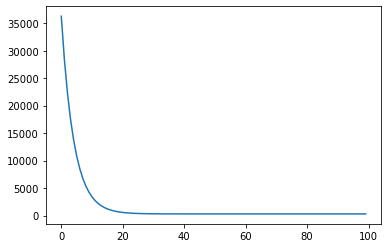

In [199]:
model = Model()

steps, errors = model.fit(x,y)

plt.plot(steps,errors)

298.6847812094617


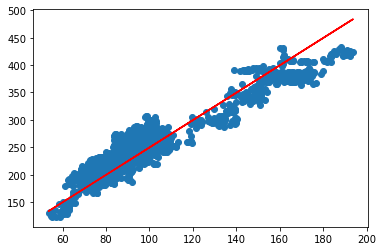

In [13]:
model = Model()
model.fit(x,y)

plt.scatter(x, y)
plt.plot(x, model.predict(x), color = 'r')

print(model.error(x,y))

# Дополнительные задания

Реализуйте механизм адаптивной скорости обучения.

In [11]:
import numpy as np

class GradientDescentLinearRegression:
    """
    Linear Regression with gradient-based optimization.
    Parameters
    ----------
    learning_rate : float
        Learning rate for the gradient descent algorithm.
    max_iterations : int
        Maximum number of iteration for the gradient descent algorithm.
    eps : float
        Tolerance level for the Euclidean norm between model parameters in two 
        consequitive iterations. The algorithm is stopped when the norm becomes 
        less than the tolerance level.
    """
    
    def __init__(self, learning_rate=1, max_iterations=10000, eps=1e-6):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.eps = eps
        
    def predict(self, X):
        """Returns predictions array of shape [n_samples,1]"""
        return np.dot(X, self.w.T)
    
    def cost(self, X, y):
        """Returns the value of the cost function as a scalar real number"""
        y_pred = self.predict(X)
        loss = (y - y_pred)**2
        return np.mean(loss)

    def grad(self, X, y):
        """Returns the gradient vector"""
        y_pred = self.predict(X)
        d_intercept = -2*sum(y - y_pred)                    # dJ/d w_0.
        d_x = -2*sum(X[:,1:] * (y - y_pred).reshape(-1,1))  # dJ/d w_i.
        g = np.append(np.array(d_intercept), d_x)           # Gradient.
        return g / X.shape[0]                               # Average over training samples.

    def adagrad(self, g):
        self.G += g**2                                     # Update cache.
        step = self.learning_rate / (np.sqrt(self.G + self.eps)) * g
        return step
        
    def fit(self, X, y, method = "adagrad", verbose = True):
        """
        Fit linear model with gradient descent.
        
        Parameters
        ----------
        X : numpy array or sparse matrix of shape [n_samples,n_predictors]
            Training data
        y : numpy array of shape [n_samples,1]
            Target values.
        method : string
                 Defines the variant of gradient descent to use. 
                 Possible values: "standard", "adagrad".
        verbose: boolean
                 If True, print the gradient, parameters and the cost function 
                 for each iteration.
        
        Returns
        -------
        self : returns an instance of self.
        """
        
        self.w = np.zeros(X.shape[1])                     # Initialization of params.
        if method == "adagrad":
            self.G = np.zeros(X.shape[1])                 # Initialization of cache for AdaGrad.
        w_hist = [self.w]                                 # History of params.
        cost_hist = [self.cost(X, y)]                     # History of cost.      
        
        for iter in range(self.max_iterations):
            
            g = self.grad(X, y)                           # Calculate the gradient.
            if method == "standard":
                step = self.learning_rate * g             # Calculate standard gradient step.
            elif method == "adagrad":
                step = self.adagrad(g)                    # Calculate AdaGrad step.
            else:
                raise ValueError("Method not supported.")
            self.w = self.w - step                        # Update parameters.
            w_hist.append(self.w)                         # Save to history.
            
            J = self.cost(X, y)                           # Calculate the cost.
            cost_hist.append(J)                           # Save to history.
            
            if verbose:
                print(f"Iter: {iter}, gradient: {g}, params: {self.w}, cost: {J}")
            
            # Stop if update is small enough.
            if np.linalg.norm(w_hist[-1] - w_hist[-2]) < self.eps:
                break
        
        # Final updates before finishing.
        self.iterations = iter + 1                       # Due to zero-based indexing.
        self.w_hist = w_hist
        self.cost_hist = cost_hist
        self.method = method
        
        return self

In [304]:
class Model:
    def __init__(self):
        self.b0 = 0 # поля классов
        self.b1 = 0
        
    def predict(self,x):
        return self.b0 + self.b1 * ((x - self.min) / self.wide)
    
    def error(self, x, y):
        return sum(((self.predict(x) - y)**2)) / (2*len(y))
    
    def fit(self, x, y):
        alpha = 0.8 # начальное альфа
        errors = []
        steps = []
        
        self.wide = x.max(axis=0) - x.min(axis=0) # нормализация
        self.min = x.min(axis=0)
        
        for i in range(100):
            steps.append(i)
            errors.append(self.error(x,y))
            dJ0 = sum(self.predict(x) - y) / len(y) # градиент
            dJ1 = sum((self.predict(x) - y) * (x - self.min) / self.wide) / len(y) # градиент с нормализацией
            self.b0 -= dJ0 * alpha
            self.b1 -= dJ1 * alpha
            if self.error(x,y) > errors[-1]:
                alpha /= 2 # уменьшение альфы со временем позволяет увеличить точность
                self.__init__()
        return steps, errors

177.00853047716507


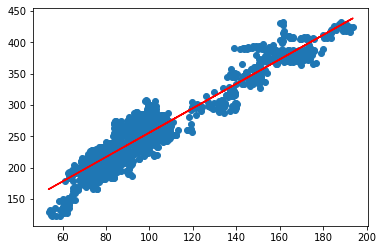

In [305]:
model = Model()

mvid = pd.read_csv('MVID_101001_171001.txt')
sber = pd.read_csv('SBER_101001_171001.txt')
res = pd.merge(sber,mvid, on='<DATE>')

x = res['<CLOSE>_x']
y = res['<CLOSE>_y']

model.fit(x,y)

plt.scatter(x, y)
plt.plot(x, model.predict(x), color = 'r')

print(model.error(x,y))

Постройте модель регрессии на другой паре инструментов.

27097.205414701595


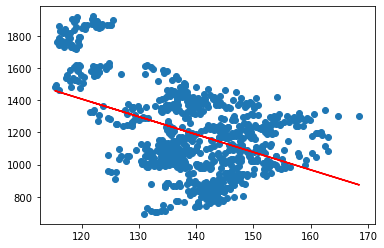

In [302]:
model = Model()

mvid = pd.read_csv('YNDX_101001_171001.txt')
sber = pd.read_csv('GAZP_101001_171001.txt')
res = pd.merge(sber,mvid, on='<DATE>')

x = res['<CLOSE>_x']
y = res['<CLOSE>_y']

model.fit(x,y)

plt.scatter(x, y)
plt.plot(x, model.predict(x), color = 'r')

print(model.error(x,y))

Модифицируйте класс регрессии так, чтобы он проводил обучение только на случайно выделенной части данных (обучающей выборке). 

In [280]:
# chosen_x = np.random.choice(x, replace=False, size=50)
# chosen_x

In [285]:
class Model:
    def __init__(self):
        self.b0 = 0 # поля классов
        self.b1 = 0
    def predict(self,x):
#         chosen_x = np.random.choice(x, replace=False, size=50)
        return self.b0 + self.b1*x
    def error(self, x, y):
#         chosen_x = np.random.choice(x, replace=False, size=50)
#         chosen_y = np.random.choice(y, replace=False, size=50)
        return sum(((self.predict(x) - y)**2)) / (2*len(y))
    def fit(self, x, y):
#         chosen_x = np.random.choice(x, replace=False, size=50)
#         chosen_y = np.random.choice(y, replace=False, size=50)
        alpha = 0.00001 # начальное альфа
        errors = []
        steps = []
        for i in range(10):
            steps.append(i)
            errors.append(self.error(x, y))
            dJ0 = sum((self.predict(x) - y)) / len(y) # градиент
            dJ1 = sum(((self.predict(x) - y)*x)) / len(y) # градиент
            self.b0 -= dJ0 * alpha
            self.b1 -= dJ1 * alpha
            if i > 0:
                if errors[-2] < errors[-1]:
                    alpha /= 10 # уменьшение альфы со временем позволяет увеличить точность
        return steps, errors

0      125.00
1      151.65
2      143.20
3      134.95
4      136.90
        ...  
295    133.95
296    122.34
297    143.60
298    135.00
299    136.50
Length: 300, dtype: float64
58924.01352727309


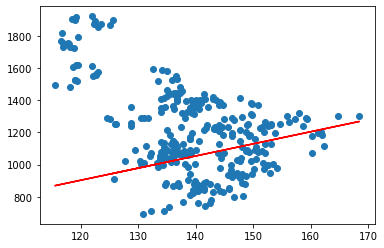

In [286]:
model = Model()

x = res['<CLOSE>_x']
y = res['<CLOSE>_y']

chosen = np.random.choice(len(x), replace=False, size=300)
chosen_y = []
chosen_x = []
for index in chosen:
    chosen_y.append(y[index])
    chosen_x.append(x[index])
chosen_y = pd.Series(chosen_y)
chosen_x = pd.Series(chosen_x)

print(chosen_x)
    
model.fit(x,y)

plt.scatter(chosen_x, chosen_y)
plt.plot(chosen_x, model.predict(chosen_x), color = 'r')

print(model.error(chosen_x,chosen_y))

Историю динамики ошибки отслеживать отдельно по обучающей и по тестовой выборке.

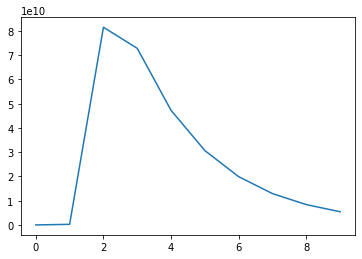

In [283]:
model = Model()

x = res['<CLOSE>_x']
y = res['<CLOSE>_y']

steps, errors = model.fit(x,y)

plt.plot(steps,errors)

[154.55 147.43 146.3  134.65 148.1  146.6  141.84 134.07 142.75 115.75
 143.59 145.5  120.6  144.5  139.25 140.4  134.88 136.25 131.01 137.15
 135.94 133.4  147.5  143.94 135.05 141.8  135.26 134.61 132.41 148.11
 139.49 138.54 144.5  144.7  147.44 136.5  140.62 135.3  150.15 139.5
 141.8  137.49 142.75 119.05 145.5  142.54 153.65 142.7  138.7  140.88]


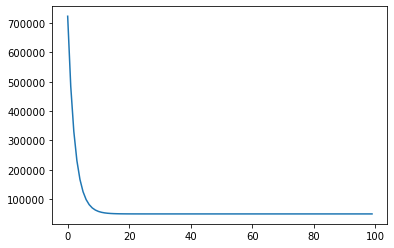

In [216]:
model = Model()

x = res['<CLOSE>_x']
y = res['<CLOSE>_y']
chosen_x = np.random.choice(x, replace=False, size=50)
chosen_y = np.random.choice(y, replace=False, size=50)

steps, errors = model.fit(chosen_x,chosen_y)

plt.plot(steps,errors)

print(chosen_x)

Научиться использовать библиотеку sklearn для построения парной линейной регрессии:

In [217]:
import sklearn as sk
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

x3 = np.array(res['<CLOSE>_x'])
y3 = np.array(res['<CLOSE>_y'])

In [218]:
x3 = x3.reshape((-1,1))
# x = x.reshape((-1, 1))
reg=linear_model.LinearRegression()
reg.fit(x3,y3)
print(reg.score(x3,y3))

0.24092152512857645


Коэффициент alpha: 
 [-12.75716657]
Среднеквадратичная ошибка: 53872.88
Коэффициент детерминации: 0.24


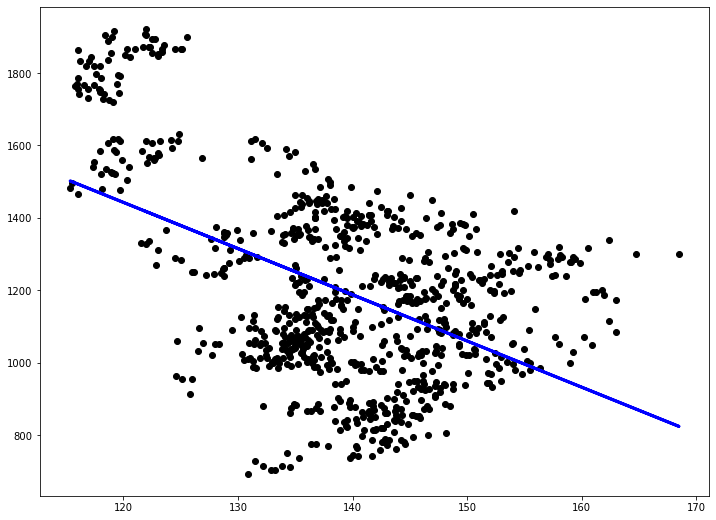

In [264]:
y_pred = reg.predict(x3)
y_pred = y_pred.reshape((-1, 1))
                        
print("Коэффициент alpha: \n", reg.coef_)
print("Среднеквадратичная ошибка: %.2f" % mean_squared_error(y3, y_pred))
print("Коэффициент детерминации: %.2f" % r2_score(y3, y_pred))

plt.figure(figsize=(12, 9))
plt.scatter(x3, y3, color="black")
plt.plot(x3, y_pred, color="blue", linewidth=3)
plt.show()

Изучить официальную документацию библиотеки sklearn: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
По примеру программы регрессии, рассмотренной на семинаре, построить модель регрессии с использованием библиотечных средств
Сравнить результаты регрессии с использованием библиотечной функции и написанной самостоятельно.